<a href="https://colab.research.google.com/github/meysam-kazemi/drive-unet/blob/main/unet_patches.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd drive/MyDrive/RETINAL/

/content/drive/.shortcut-targets-by-id/19v_-z68QIom5bSkKsoiETI2xN8cPjPox/RETINAL


In [ ]:
%ls

 augment.ipynb                 outputs/
'Copy of unet_patches.ipynb'   presentation.gslides
 datasets/                     seminar_report_finalـ.docx
 drive_dataset.png             test/
 figs/                         test.zip
 figsdrive_dataset.png         training/
 files/                        training.zip
 fr-unet.ipynb                 unet-2.ipynb
 FR-Unet_patches.ipynb         unet.ipynb
 kazemi.doc                    unet_model_image-random-patches-finetune-90-final.pth
 loss_plot.png                 unet_patches.ipynb
 models/                       unet-without-anything.pth
 new_data/


In [ ]:
MODEL_PATH = "models/unet_model_image_random_patches_65.pth"
NUM_EPOCHS = 65
MODEL_PATH_FINETUNED = "unet_model_image-random-patches-finetune-90-final.pth"
NUM_EPOCHS_FINETUNED = 90

In [ ]:
# Libraries

import os
import time
import random
import numpy as np
import cv2
import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
from glob import glob
from torch.utils.data import DataLoader
from torch.cuda.amp import GradScaler, autocast
import cv2
import time
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
# Utils

def add_metric_history(metrics, hist):
    for k, _ in hist.items():
      hist[k].append(metrics[k])
    return hist


""" Seeding the randomness. """
def seeding(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

""" Create a directory. """
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

""" Calculate the time taken """
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
# Data

class DriveDataset(Dataset):
    def __init__(self, images_path, masks_path):

        self.images_path = images_path
        self.masks_path = masks_path
        self.n_samples = len(images_path)

    def __getitem__(self, index):
        """ Reading image """
        image = cv2.imread(self.images_path[index], 0)  # gray scale
        image = image/255.0 ## (512, 512)
        # image = np.transpose(image, (2, 0, 1))  ## (3, 512, 512)
        image = np.expand_dims(image, axis=0)  # (1, 512, 512)
        image = image.astype(np.float32)
        image = torch.from_numpy(image)

        """ Reading mask """
        mask = cv2.imread(self.masks_path[index], cv2.IMREAD_GRAYSCALE)
        mask = mask/255.0   ## (512, 512)
        mask = np.expand_dims(mask, axis=0) ## (1, 512, 512)
        mask = (mask > 0.5)*1 # binarize
        mask = mask.astype(np.float32)
        mask = torch.from_numpy(mask)

        return image, mask

    def __len__(self):
        return self.n_samples

# Loss

In [ ]:
# Loss

class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)

        return 1 - dice

class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        #comment out if your model contains a sigmoid or equivalent activation layer
        # inputs = torch.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss

        return Dice_BCE

## Metrics

In [ ]:
import numpy as np
import torch
import cv2
from sklearn.metrics import roc_auc_score

def get_metrics(predict, target, threshold=None, predict_b=None):
    predict = torch.sigmoid(predict).cpu().detach().numpy().flatten()
    if predict_b is not None:
        predict_b = predict_b.flatten()
    else:
        predict_b = np.where(predict >= threshold, 1, 0)
    if torch.is_tensor(target):
        target = target.cpu().detach().numpy().flatten()
    else:
        target = target.flatten()
    tp = (predict_b * target).sum()
    tn = ((1 - predict_b) * (1 - target)).sum()
    fp = ((1 - target) * predict_b).sum()
    fn = ((1 - predict_b) * target).sum()
    auc = roc_auc_score(target>0.5, predict)
    acc = (tp + tn) / (tp + fp + fn + tn)
    pre = tp / (tp + fp)
    sen = tp / (tp + fn)
    spe = tn / (tn + fp)
    iou = tp / (tp + fp + fn)
    f1 = 2 * pre * sen / (pre + sen)
    return {
        "AUC": np.round(auc, 4),
        "F1": np.round(f1, 4),
        "Acc": np.round(acc, 4),
        "Sen": np.round(sen, 4),
        "Spe": np.round(spe, 4),
        "Pre": np.round(pre, 4),
        "IOU": np.round(iou, 4),
    }


def count_connect_component(predict, target, threshold=None, connectivity=8):
    if threshold != None:
        predict = torch.sigmoid(predict).cpu().detach().numpy()
        predict = np.where(predict >= threshold, 1, 0)
    if torch.is_tensor(target):
        target = target.cpu().detach().numpy()
    pre_n, _, _, _ = cv2.connectedComponentsWithStats(np.asarray(
        predict, dtype=np.uint8)*255, connectivity=connectivity)
    gt_n, _, _, _ = cv2.connectedComponentsWithStats(np.asarray(
        target, dtype=np.uint8)*255, connectivity=connectivity)
    return pre_n/gt_n

# Unet

In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.utils import save_image
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

In [ ]:
# Model

class conv_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_c)

        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_c)

        self.relu = nn.ReLU()

    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        return x

class encoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv = conv_block(in_c, out_c)
        self.pool = nn.MaxPool2d((2, 2))

    def forward(self, inputs):
        x = self.conv(inputs)
        p = self.pool(x)

        return x, p

class decoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
        self.conv = conv_block(out_c+out_c, out_c)

    def forward(self, inputs, skip):
        x = self.up(inputs)
        x = torch.cat([x, skip], axis=1)
        x = self.conv(x)
        return x

class build_unet(nn.Module):
    def __init__(self):
        super().__init__()

        """ Encoder """
        self.e1 = encoder_block(1, 16)
        self.e2 = encoder_block(16, 32)
        self.e3 = encoder_block(32, 64)
        self.e4 = encoder_block(64, 128)

        """ Bottleneck """
        self.b = conv_block(128, 256)

        """ Decoder """
        self.d1 = decoder_block(256, 128)
        self.d2 = decoder_block(128, 64)
        self.d3 = decoder_block(64, 32)
        self.d4 = decoder_block(32, 16)

        """ Classifier """
        self.outputs = nn.Conv2d(16, 1, kernel_size=1, padding=0)

    def forward(self, inputs):
        """ Encoder """
        s1, p1 = self.e1(inputs)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)

        """ Bottleneck """
        b = self.b(p4)

        """ Decoder """
        d1 = self.d1(b, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)

        outputs = self.outputs(d4)

        return outputs

x = torch.randn((2, 1, 512, 512)).to(0)
model = build_unet().to(0)
y = model(x)
print(y.shape)

torch.Size([2, 1, 512, 512])


In [ ]:
from torchsummary import summary
summary(model, (1,512,512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 512, 512]             160
       BatchNorm2d-2         [-1, 16, 512, 512]              32
              ReLU-3         [-1, 16, 512, 512]               0
            Conv2d-4         [-1, 16, 512, 512]           2,320
       BatchNorm2d-5         [-1, 16, 512, 512]              32
              ReLU-6         [-1, 16, 512, 512]               0
        conv_block-7         [-1, 16, 512, 512]               0
         MaxPool2d-8         [-1, 16, 256, 256]               0
     encoder_block-9  [[-1, 16, 512, 512], [-1, 16, 256, 256]]               0
           Conv2d-10         [-1, 32, 256, 256]           4,640
      BatchNorm2d-11         [-1, 32, 256, 256]              64
             ReLU-12         [-1, 32, 256, 256]               0
           Conv2d-13         [-1, 32, 256, 256]           9,248
      BatchNorm2d-14    

# Train

In [ ]:
""" Seeding """
seeding(42)

# """ Load dataset """
# train_x = sorted(glob("./datasets/DRIVE/patches/train/images/*"))
# train_y = sorted(glob("./datasets/DRIVE/patches/train/masks/*"))

# test_x = sorted(glob("./datasets/DRIVE/patches/test/images/*"))
# test_y = sorted(glob("./datasets/DRIVE/patches/test/masks/*"))

train_x = sorted(glob("./datasets/DRIVE/image_random_patches/images/*"))
train_y = sorted(glob("./datasets/DRIVE/image_random_patches/masks/*"))

In [ ]:
""" Hyperparameters """
batch_size = 8
num_epochs = 60
lr = 1e-4

""" Dataset and loader """
train_dataset = DriveDataset(train_x, train_y)
# test_dataset = DriveDataset(test_x, test_y)
validation_split = 0.2
train_size = int((1 - validation_split) * len(train_dataset))
valid_size = len(train_dataset) - train_size
# split dataset to train and valid
# test_dataset, valid_dataset = random_split(test_dataset, [test_size, valid_size])
test_dataset, valid_dataset = random_split(train_dataset, [train_size, valid_size])


train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    # num_workers=2
)

valid_loader = DataLoader(
    dataset=valid_dataset,
    batch_size=batch_size,
    shuffle=False,
    # num_workers=2
)

# test_loader = DataLoader(
#     dataset=test_dataset,
#     batch_size=batch_size,
#     shuffle=False,
#     # num_workers=2
# )


# print(f"Dataset Size:\n  Train: {len(train_loader)}\n  Valid: {len(valid_loader)}\n  Test: {len(test_loader)}")
print(f"Dataset Size:\n  Train: {len(train_loader)}\n  Valid: {len(valid_loader)}\n")

NameError: name 'train_x' is not defined

In [ ]:
model = model.to(0)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, verbose=True)
# loss_fn = DiceBCELoss()
loss_fn = DiceLoss()
scaler = torch.amp.GradScaler('cuda')

In [ ]:
#  """load pre-trained model"""
# checkpoint = torch.load("models/unet_model.pth")
# model.load_state_dict(checkpoint['model'])
# optimizer.load_state_dict(checkpoint['optimizer'])
# scheduler.load_state_dict(checkpoint['scheduler'])
# history = checkpoint['history']
# init_epoch = history['epoch'][-1]+1
# valid_metric_hist = checkpoint['valid_metric_history']
# train_metric_hist =checkpoint['train_metric_history']

In [ ]:
init_epoch = 1

In [ ]:
create_dir("outputs/unet-training-image_random_patches/")

In [ ]:
# from torch.utils.tensorboard import SummaryWriter
# writer = SummaryWriter()

In [ ]:
# """load pre-trained model"""
# checkpoint = torch.load("models/.pth")
# model.load_state_dict(checkpoint['state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer'])
# scheduler.load_state_dict(checkpoint['scheduler'])
# init_epoch = checkpoint['epoch']

In [ ]:
# sigm = nn.functional.sigmoid
def train(model, loader, optimizer, loss_fn, scale,  amp=True):
    epoch_loss = 0.0

    model.train()
    for x, y in loader:
        x = x.to("cuda")
        y = y.to("cuda")

        optimizer.zero_grad()

        if amp:
            with torch.amp.autocast('cuda'):  # Enable mixed precision
                outputs = model(x)
                loss = loss_fn(outputs, y)

            scaler.scale(loss).backward()  # Scale the loss and backpropagate
            scaler.step(optimizer)  # Step the optimizer
            scaler.update()  # Update the scaler
        else:
            outputs = model(x)
            loss = loss_fn(outputs, y)
            loss.backward()
            optimizer.step()


        epoch_loss += loss.item()

    epoch_loss = epoch_loss/len(loader)
    return x,y, outputs, epoch_loss

def evaluate(model, loader, loss_fn, amp=False):
    epoch_loss = 0.0

    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x = x.to("cuda")
            y = y.to("cuda")
            if amp:
                with torch.amp.autocast('cuda'):  # Enable mixed precision
                    outputs = model(x)
                    loss = loss_fn(outputs, y)

            else:
                outputs = model(x)
                loss = loss_fn(outputs, y)



            epoch_loss += loss.item()

        epoch_loss = epoch_loss/(len(loader))
    return x,y, outputs, epoch_loss

In [ ]:
torch.cuda.empty_cache()

In [ ]:
# init_epoch = epoch
# num_epochs = 60

In [ ]:
""" Training the model """
best_valid_loss = float("inf")
history = {'epoch': [], 'train_loss': [], 'valid_loss': [], "time": []}
train_metric_hist = {'AUC':[],'F1':[],'Acc':[],'Sen':[],'Spe':[],'Pre':[],'IOU':[]}
valid_metric_hist = {'AUC':[],'F1':[],'Acc':[],'Sen':[],'Spe':[],'Pre':[],'IOU':[]}

for epoch in range(init_epoch, NUM_EPOCHS+1):
    start_time = time.time()

    x_tr, y_tr, outputs_tr, train_loss = train(model, train_loader, optimizer, loss_fn, scaler, True)
    x_val, y_val, outputs_val, valid_loss = evaluate(model, valid_loader, loss_fn, amp=True)
    # History
    history['train_loss'].append(train_loss)
    history['valid_loss'].append(valid_loss)
    history['epoch'].append(epoch)
    ep_time = round(time.time()-start_time, 2)
    history['time'].append(ep_time)

    # metrics
    metric_train = get_metrics(predict=outputs_tr, target=y_tr,threshold=0.5)
    metric_valid = get_metrics(predict=outputs_val, target=y_val, threshold=0.5)

    train_metric_hist = add_metric_history(metric_train, train_metric_hist)
    valid_metric_hist = add_metric_history(metric_valid, valid_metric_hist)

    print(f'Epoch [{epoch}/{NUM_EPOCHS}] | Train Loss: {train_loss:.4f} | Valid Loss: {valid_loss:.4f} | Time : {ep_time} s')

    # Save the model and images every 10 epochs
    if (epoch) % 10 == 0:
        state = {
        'history': history,
        'train_metric_history': train_metric_hist,
        'valid_metric_history': valid_metric_hist,
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'scheduler': scheduler.state_dict(),
        'epoch' : epoch
        }
        torch.save(state, MODEL_PATH)

        # Save 9 image results
        folder_path = f'outputs/unet_training_image_random_patches/results/epoch{epoch}/'
        create_dir(folder_path)
        save_image(x_val.cpu(), folder_path+'images.png', nrow=2, normalize=True)
        save_image(y_val.cpu(), folder_path+'original_masks.png', nrow=2, normalize=True)
        save_image(outputs_val.cpu(), folder_path+'outputs.png', nrow=2, normalize=True)

    """ Saving the model """
    if valid_loss < best_valid_loss:
        data_str = "\033[33mValid loss improved\033[00m"
        print(data_str)

        best_valid_loss = valid_loss
        torch.save(model.state_dict(), "models/best-unet-40-epoch.pth")

Epoch [1/60] | Train Loss: 0.6977 | Valid Loss: 0.8394 | Time : 46.49 s
Valid loss improved
Epoch [2/60] | Train Loss: 0.5885 | Valid Loss: 0.5681 | Time : 44.23 s
Valid loss improved
Epoch [3/60] | Train Loss: 0.5399 | Valid Loss: 0.5293 | Time : 45.2 s
Valid loss improved
Epoch [4/60] | Train Loss: 0.5014 | Valid Loss: 0.4796 | Time : 44.64 s
Valid loss improved
Epoch [5/60] | Train Loss: 0.4670 | Valid Loss: 0.4399 | Time : 45.02 s
Valid loss improved
Epoch [6/60] | Train Loss: 0.4333 | Valid Loss: 0.4120 | Time : 44.73 s
Valid loss improved
Epoch [7/60] | Train Loss: 0.3995 | Valid Loss: 0.3800 | Time : 44.84 s
Valid loss improved
Epoch [8/60] | Train Loss: 0.3668 | Valid Loss: 0.3478 | Time : 45.09 s
Valid loss improved
Epoch [9/60] | Train Loss: 0.3378 | Valid Loss: 0.3344 | Time : 45.05 s
Valid loss improved
Epoch [10/60] | Train Loss: 0.3104 | Valid Loss: 0.2983 | Time : 45.17 s
Valid loss improved
Epoch [11/60] | Train Loss: 0.2837 | Valid Loss: 0.2733 | Time : 46.51 s
Valid l

## test

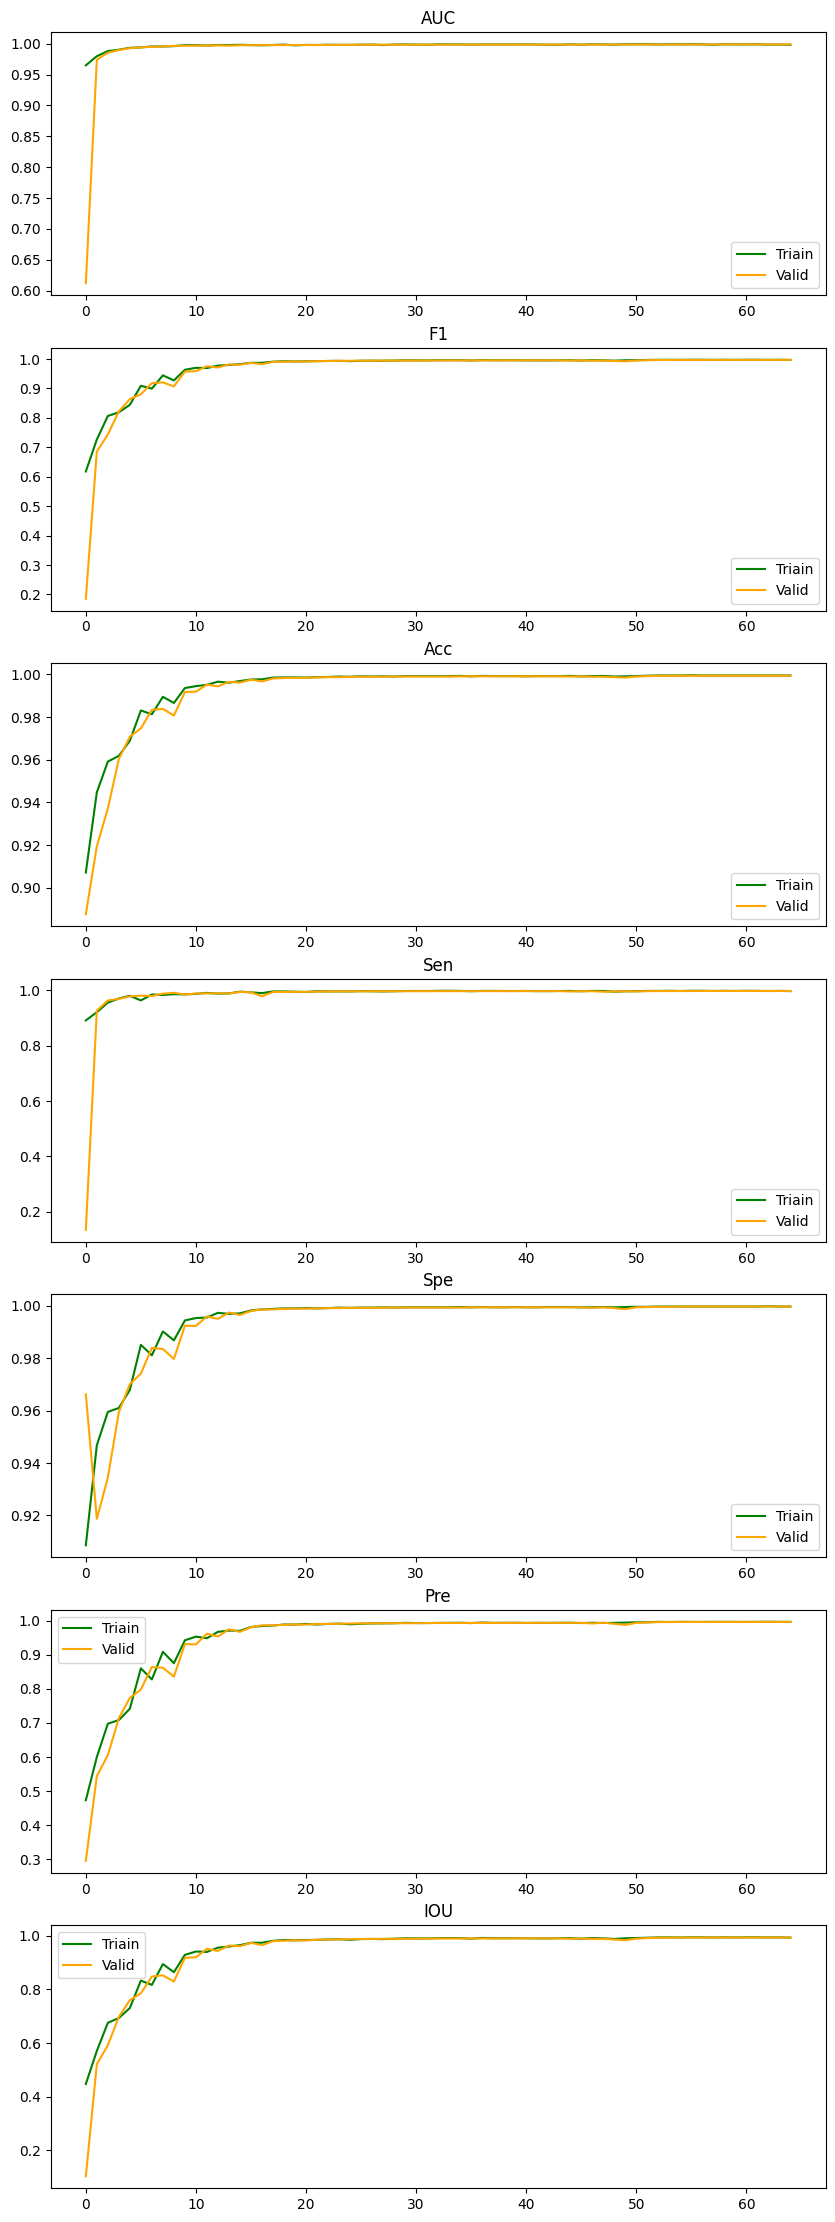

In [ ]:
fig, axs = plt.subplots(7,1, figsize=(10,28))
for i, (k,v) in enumerate(train_metric_hist.items()):
  axs[i].plot(v, c='green', label="Triain")
for i, (k,v) in enumerate(valid_metric_hist.items()):
  axs[i].plot(v, c='orange', label="Valid")
  axs[i].set_title(k)
  axs[i].legend()


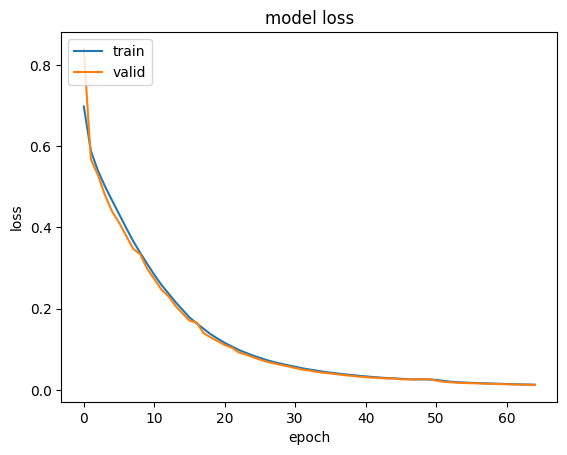

In [ ]:
fig2 = plt.figure()
plt.plot(history['train_loss'])
plt.plot(history['valid_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')

In [ ]:
create_dir("figs")
fig2.savefig('figs/loss_plot_image_random_patches_65.png')

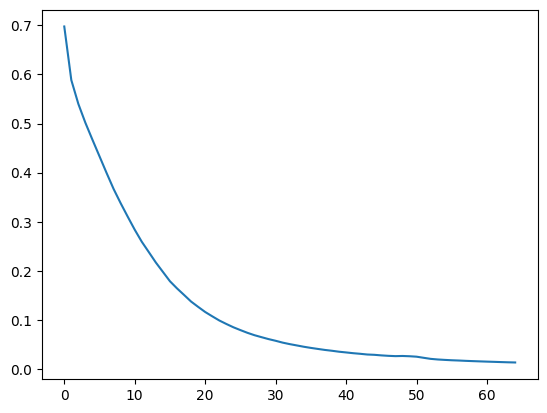

In [ ]:
plt.plot(history['train_loss'])

## Train

In [ ]:
torch.cuda.empty_cach()

In [ ]:
# Test

import os, time
from operator import add
import numpy as np
from glob import glob
import cv2
from tqdm import tqdm
import imageio
import torch
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, precision_score, recall_score

from model import build_unet
from utils import create_dir, seeding

def calculate_metrics(y_true, y_pred):
    """ Ground truth """
    y_true = y_true.cpu().numpy()
    y_true = y_true > 0.5
    y_true = y_true.astype(np.uint8)
    y_true = y_true.reshape(-1)

    """ Prediction """
    y_pred = y_pred.cpu().numpy()
    y_pred = y_pred > 0.5
    y_pred = y_pred.astype(np.uint8)
    y_pred = y_pred.reshape(-1)

    score_jaccard = jaccard_score(y_true, y_pred)
    score_f1 = f1_score(y_true, y_pred)
    score_recall = recall_score(y_true, y_pred)
    score_precision = precision_score(y_true, y_pred)
    score_acc = accuracy_score(y_true, y_pred)

    return [score_jaccard, score_f1, score_recall, score_precision, score_acc]

def mask_parse(mask):
    mask = np.expand_dims(mask, axis=-1)    ## (512, 512, 1)
    mask = np.concatenate([mask, mask, mask], axis=-1)  ## (512, 512, 3)
    return mask

if __name__ == "__main__":
    """ Seeding """
    seeding(42)

    """ Folders """
    create_dir("results")

    """ Load dataset """
    test_x = sorted(glob("../new_data/test/image/*"))
    test_y = sorted(glob("../new_data/test/mask/*"))

    """ Hyperparameters """
    H = 512
    W = 512
    size = (W, H)
    checkpoint_path = "files/checkpoint.pth"

    """ Load the checkpoint """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model = build_unet()
    model = model.to(device)
    model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    model.eval()

    metrics_score = [0.0, 0.0, 0.0, 0.0, 0.0]
    time_taken = []

    for i, (x, y) in tqdm(enumerate(zip(test_x, test_y)), total=len(test_x)):
        """ Extract the name """
        name = x.split("/")[-1].split(".")[0]

        """ Reading image """
        image = cv2.imread(x, cv2.IMREAD_COLOR) ## (512, 512, 3)
        ## image = cv2.resize(image, size)
        x = np.transpose(image, (2, 0, 1))      ## (3, 512, 512)
        x = x/255.0
        x = np.expand_dims(x, axis=0)           ## (1, 3, 512, 512)
        x = x.astype(np.float32)
        x = torch.from_numpy(x)
        x = x.to(device)

        """ Reading mask """
        mask = cv2.imread(y, cv2.IMREAD_GRAYSCALE)  ## (512, 512)
        ## mask = cv2.resize(mask, size)
        y = np.expand_dims(mask, axis=0)            ## (1, 512, 512)
        y = y/255.0
        y = np.expand_dims(y, axis=0)               ## (1, 1, 512, 512)
        y = y.astype(np.float32)
        y = torch.from_numpy(y)
        y = y.to(device)

        with torch.no_grad():
            """ Prediction and Calculating FPS """
            start_time = time.time()
            pred_y = model(x)
            pred_y = torch.sigmoid(pred_y)
            total_time = time.time() - start_time
            time_taken.append(total_time)


            score = calculate_metrics(y, pred_y)
            metrics_score = list(map(add, metrics_score, score))
            pred_y = pred_y[0].cpu().numpy()        ## (1, 512, 512)
            pred_y = np.squeeze(pred_y, axis=0)     ## (512, 512)
            pred_y = pred_y > 0.5
            pred_y = np.array(pred_y, dtype=np.uint8)

        """ Saving masks """
        ori_mask = mask_parse(mask)
        pred_y = mask_parse(pred_y)
        line = np.ones((size[1], 10, 3)) * 128

        cat_images = np.concatenate(
            [image, line, ori_mask, line, pred_y * 255], axis=1
        )
        cv2.imwrite(f"results/{name}.png", cat_images)

    jaccard = metrics_score[0]/len(test_x)
    f1 = metrics_score[1]/len(test_x)
    recall = metrics_score[2]/len(test_x)
    precision = metrics_score[3]/len(test_x)
    acc = metrics_score[4]/len(test_x)
    print(f"Jaccard: {jaccard:1.4f} - F1: {f1:1.4f} - Recall: {recall:1.4f} - Precision: {precision:1.4f} - Acc: {acc:1.4f}")

    fps = 1/np.mean(time_taken)
    print("FPS: ", fps)

# load checkpoint

In [ ]:
model = model.to(0)
lr = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)
# loss_fn = DiceBCELoss()
loss_fn = DiceLoss()
scaler = torch.amp.GradScaler('cuda')

In [ ]:
"""load pre-trained model"""
checkpoint = torch.load(MODEL_PATH)
model.load_state_dict(checkpoint['model'])
optimizer.load_state_dict(checkpoint['optimizer'])
scheduler.load_state_dict(checkpoint['scheduler'])
init_epoch = checkpoint['epoch']
valid_metric_hist = checkpoint['valid_metric_history']
train_metric_hist = checkpoint['train_metric_history']
history = checkpoint['history']

<ipython-input-30-d5fd3adb7e56>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(MODEL_PATH)


# Fine-tune

In [ ]:
""" Seeding """
seeding(42)

""" Load dataset """
train_x = sorted(glob("./datasets/DRIVE/train-png/images/*"))
train_y = sorted(glob("./datasets/DRIVE/train-png/masks/*"))

test_x = sorted(glob("./datasets/DRIVE/test-png/images/*"))
test_y = sorted(glob("./datasets/DRIVE/test-png/masks/*"))

In [ ]:
""" Hyperparameters """
batch_size = 8

""" Dataset and loader """
train_dataset = DriveDataset(train_x, train_y)
test_dataset = DriveDataset(test_x, test_y)
validation_split = 0.5
test_size = int((1 - validation_split) * len(test_dataset))
valid_size = len(test_dataset) - test_size
# split dataset to train and valid
_, valid_dataset = random_split(test_dataset, [test_size, valid_size])


train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2
)

valid_loader = DataLoader(
    dataset=valid_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2
)


print(f"Dataset Size:\n  Train: {len(train_loader)}\n  Valid: {len(valid_loader)}\n  Test: {len(test_loader)}")

Dataset Size:
  Train: 3
  Valid: 2
  Test: 3


In [ ]:
""" Training the model """
best_valid_loss = float("inf")
# history = {'epoch': [], 'train_loss': [], 'valid_loss': [], "time": []}
# train_metric_hist = {'AUC':[],'F1':[],'Acc':[],'Sen':[],'Spe':[],'Pre':[],'IOU':[]}
# valid_metric_hist = {'AUC':[],'F1':[],'Acc':[],'Sen':[],'Spe':[],'Pre':[],'IOU':[]}
NUM_EPOCHS = 60
NUM_EPOCHS_FINETUNED = 90
for epoch in range(NUM_EPOCHS+1, NUM_EPOCHS_FINETUNED+1):
    start_time = time.time()

    x_tr, y_tr, outputs_tr, train_loss = train(model, train_loader, optimizer, loss_fn, scaler, True)
    x_val, y_val, outputs_val, valid_loss = evaluate(model, valid_loader, loss_fn, amp=True)
    # History
    history['train_loss'].append(train_loss)
    history['valid_loss'].append(valid_loss)
    history['epoch'].append(epoch)
    ep_time = round(time.time()-start_time, 2)
    history['time'].append(ep_time)

    # metrics
    metric_train = get_metrics(predict=outputs_tr, target=y_tr,threshold=0.5)
    metric_valid = get_metrics(predict=outputs_val, target=y_val, threshold=0.5)

    train_metric_hist = add_metric_history(metric_train, train_metric_hist)
    valid_metric_hist = add_metric_history(metric_valid, valid_metric_hist)

    print(f'Epoch [{epoch}/{NUM_EPOCHS_FINETUNED}] | Train Loss: {train_loss:.4f} | Valid Loss: {valid_loss:.4f} | Time : {ep_time} s')

# Save the model and images every 10 epochs
state = {
'history': history,
'train_metric_history': train_metric_hist,
'valid_metric_history': valid_metric_hist,
'model': model.state_dict(),
'optimizer': optimizer.state_dict(),
'scheduler': scheduler.state_dict(),
'epoch' : epoch
}
torch.save(state, "models/unet-random-patches-fine-tuned.pth")

Epoch [61/90] | Train Loss: 0.0579 | Valid Loss: 0.2648 | Time : 3.73 s
Epoch [62/90] | Train Loss: 0.0544 | Valid Loss: 0.3062 | Time : 3.59 s
Epoch [63/90] | Train Loss: 0.0682 | Valid Loss: 0.2584 | Time : 3.64 s
Epoch [64/90] | Train Loss: 0.0623 | Valid Loss: 0.2743 | Time : 3.56 s
Epoch [65/90] | Train Loss: 0.0662 | Valid Loss: 0.2560 | Time : 3.33 s
Epoch [66/90] | Train Loss: 0.0711 | Valid Loss: 0.2701 | Time : 3.72 s
Epoch [67/90] | Train Loss: 0.0630 | Valid Loss: 0.2509 | Time : 3.9 s
Epoch [68/90] | Train Loss: 0.0599 | Valid Loss: 0.2605 | Time : 3.33 s
Epoch [69/90] | Train Loss: 0.0554 | Valid Loss: 0.2538 | Time : 3.31 s
Epoch [70/90] | Train Loss: 0.0451 | Valid Loss: 0.2445 | Time : 3.86 s
Epoch [71/90] | Train Loss: 0.0424 | Valid Loss: 0.2494 | Time : 3.35 s
Epoch [72/90] | Train Loss: 0.0415 | Valid Loss: 0.2719 | Time : 3.35 s
Epoch [73/90] | Train Loss: 0.0386 | Valid Loss: 0.2408 | Time : 3.58 s
Epoch [74/90] | Train Loss: 0.0352 | Valid Loss: 0.2610 | Time : 

# Plot

In [ ]:
im, mask = next(iter(train_dataset))

In [ ]:
pred = model(im.to(0)[None,...])

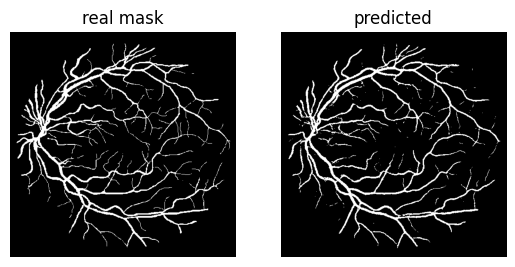

In [ ]:
fig = plt.figure()
plt.subplot(1,2,1)
plt.imshow(mask[0],'gray');plt.axis(False);plt.title("real mask")
plt.subplot(1,2,2)
plt.imshow(pred[0,0].detach().cpu()>0.5, 'gray');plt.axis(False);plt.title('predicted')
plt.savefig("figs/unet-patches-finetuned-traindata.png")

In [ ]:
valid_metric_hist['AUC'].__len__()

90

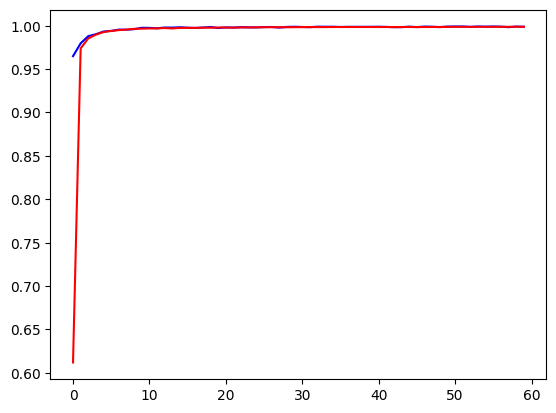

In [ ]:
plt.plot(train_metric_hist['AUC'], 'b')
plt.plot(valid_metric_hist['AUC'], 'r')

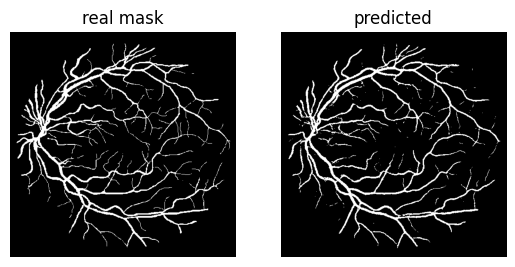

In [ ]:
im, mask = next(iter(test_dataset))
pred = model(im.to(0)[None,...])

fig = plt.figure()
plt.subplot(1,2,1)
plt.imshow(mask[0],'gray');plt.axis(False);plt.title("real mask")
plt.subplot(1,2,2)
plt.imshow(pred[0,0].detach().cpu()>0.5, 'gray');plt.axis(False);plt.title('predicted')
plt.savefig("figs/unet-patches-finetuned-traindata.png")

# Eval all models

In [ ]:
""" Seeding """
seeding(42)

""" Load dataset """
train_x = sorted(glob("./datasets/DRIVE/train-png/images/*"))
train_y = sorted(glob("./datasets/DRIVE/train-png/masks/*"))

test_x = sorted(glob("./datasets/DRIVE/test-png/images/*"))
test_y = sorted(glob("./datasets/DRIVE/test-png/masks/*"))

In [ ]:
""" Hyperparameters """
batch_size = 4

""" Dataset and loader """
train_dataset = DriveDataset(train_x, train_y)
test_dataset = DriveDataset(test_x, test_y)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2
)


print(f"Dataset Size:\n  Train: {len(train_loader)}\n  Test: {len(test_loader)}")

Dataset Size:
  Train: 5
  Test: 5


In [ ]:
model = model.to(0)
lr = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, verbose=True)
# loss_fn = DiceBCELoss()
loss_fn = DiceLoss()
scaler = torch.amp.GradScaler('cuda')

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
test = next(iter(test_loader))
train = next(iter(train_loader))

In [ ]:
unet_models = [
  ("models/unet_model.pth", "unet - augmented"),
  ("models/unet_model_patches-60-epochs.pth", "unet - patches - finetuned"),
  ("models/unet_model_patches-40-epochs.pth", "unet - patches"),
  ("models/unet_model_patches-finetune.pth", "unet - patches - finetuned2"),
  ("models/unet_model.pth", "unet - with augmented data"),
  ("models/unet_model_image_random_patches_65.pth", "unet - random patches"),
  ("models/unet-random-patches-fine-tuned.pth", "unet - random patches - finetuned"),
]

In [ ]:
def evaluate_all_models(model_path, model_name):
  """load pre-trained model"""
  checkpoint = torch.load(model_path)
  model.load_state_dict(checkpoint['model'])
  x_test, y_test, outputs_test, test_loss = evaluate(model, test_loader, loss_fn, amp=True)
  metric_test = get_metrics(predict=outputs_test, target=y_test,threshold=0.5)
  x_tr, y_tr, outputs_tr, train_loss = evaluate(model, train_loader, loss_fn, True)
  metric_train = get_metrics(predict=outputs_tr, target=y_tr,threshold=0.5)

  print(f"\t\t\t{model_name}")
  print(f"TRAIN:\n\tLoss: {train_loss}\n\tAUC: {metric_train['AUC']}\n\tIOU: {metric_train['IOU']}")
  print("-"*40)
  print(f"TEST:\n\tLoss: {test_loss}\n\tAUC: {metric_test['AUC']}\n\tIOU: {metric_test['IOU']}")

  pred_tr = model(train[0].to(0)).detach().cpu()
  pred_test = model(test[0].to(0)).detach().cpu()
  torch.cuda.empty_cache()
  f, axs = plt.subplots(4,6)
  for i, ax_row in enumerate(axs):
    ax_row[0].imshow(train[0][i][0].to('cpu'), 'gray');ax_row[0].axis(False) # original
    ax_row[1].imshow(pred_tr[i,0].detach().cpu()>0.5, 'gray');ax_row[1].axis(False)
    ax_row[2].imshow(train[1][i][0].to('cpu'), 'gray');ax_row[2].axis(False)
    ax_row[3].imshow(test[0][i][0].to('cpu'), 'gray');ax_row[3].axis(False)
    ax_row[4].imshow(pred_test[i,0]>0.5, 'gray');ax_row[4].axis(False)
    ax_row[5].imshow(test[1][i][0].to('cpu'), 'gray');ax_row[5].axis(False)
  axs[0,0].set_title("Original Train Image", fontsize=5)
  axs[0,1].set_title("Predicted Train Mask", fontsize=5)
  axs[0,2].set_title("Original Train Mask", fontsize=5)
  axs[0,3].set_title("Original Test Image", fontsize=5)
  axs[0,4].set_title("Predicted Test Mask", fontsize=5)
  axs[0,5].set_title("Original Test Mask", fontsize=5)
  f.savefig(f"figs/{model_name}.png")
  plt.show()

<ipython-input-25-97e24c7801ce>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


			unet - random patches
TRAIN:
	Loss: 0.043540990352630614
	AUC: 0.9967
	IOU: 0.9402
----------------------------------------
TEST:
	Loss: 0.22858679294586182
	AUC: 0.9515
	IOU: 0.6596


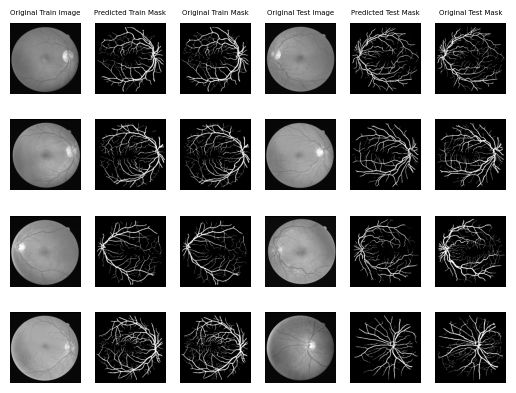

In [ ]:
evaluate_all_models(*unet_models[-2])

<ipython-input-25-97e24c7801ce>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


			unet - augmented
TRAIN:
	Loss: 0.13609756231307985
	AUC: 0.9271
	IOU: 0.7481
----------------------------------------
TEST:
	Loss: 0.209078586101532
	AUC: 0.8922
	IOU: 0.6682


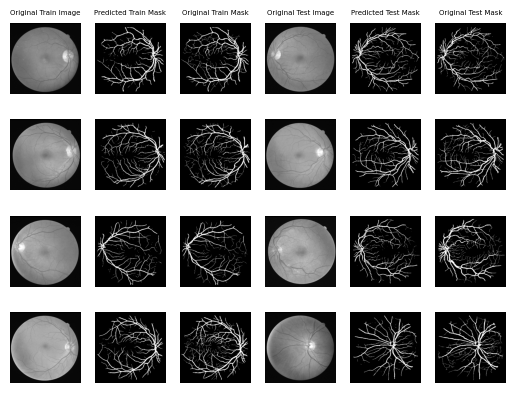

<ipython-input-25-97e24c7801ce>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


			unet - patches - finetuned
TRAIN:
	Loss: 0.5819774627685547
	AUC: 0.9894
	IOU: 0.6792
----------------------------------------
TEST:
	Loss: 0.6054276108741761
	AUC: 0.9665
	IOU: 0.6002


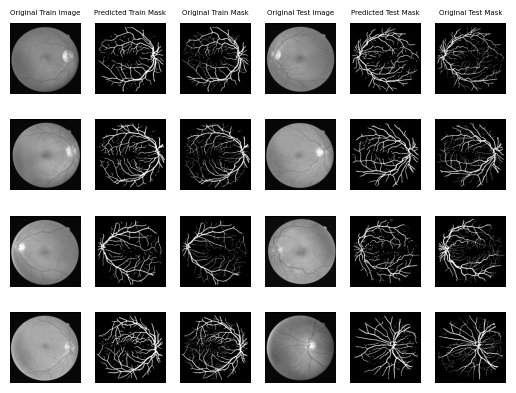

<ipython-input-25-97e24c7801ce>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


			unet - patches
TRAIN:
	Loss: 0.6075676560401917
	AUC: 0.9792
	IOU: 0.5878
----------------------------------------
TEST:
	Loss: 0.621226167678833
	AUC: 0.9698
	IOU: 0.551


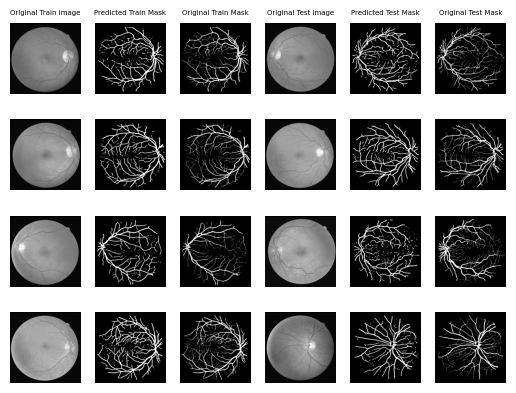

<ipython-input-25-97e24c7801ce>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


			unet - patches - finetuned
TRAIN:
	Loss: 0.004059600830078125
	AUC: 0.9996
	IOU: 0.997
----------------------------------------
TEST:
	Loss: 0.22481517791748046
	AUC: 0.9412
	IOU: 0.6508


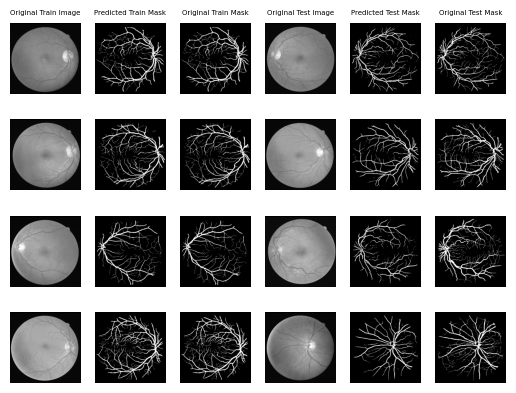

<ipython-input-25-97e24c7801ce>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


			unet - with augmented data
TRAIN:
	Loss: 0.13369834423065186
	AUC: 0.9263
	IOU: 0.771
----------------------------------------
TEST:
	Loss: 0.209078586101532
	AUC: 0.8922
	IOU: 0.6682


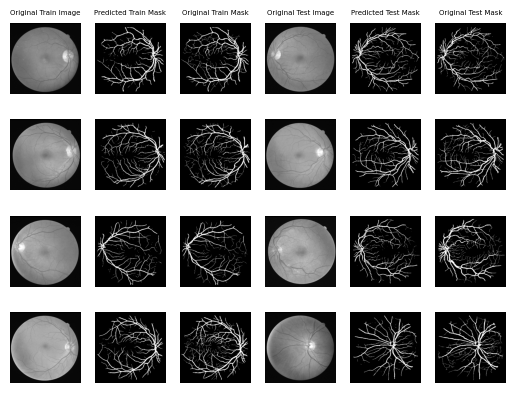

<ipython-input-25-97e24c7801ce>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


			unet - random patches
TRAIN:
	Loss: 0.043661630153656004
	AUC: 0.9968
	IOU: 0.9418
----------------------------------------
TEST:
	Loss: 0.22858679294586182
	AUC: 0.9515
	IOU: 0.6596


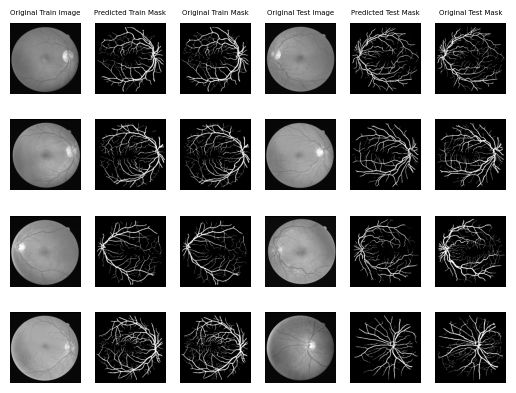

<ipython-input-25-97e24c7801ce>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


FileNotFoundError: [Errno 2] No such file or directory: 'models/unet-random-patches-fine-tuned.pth'

In [ ]:
for unet_model in unet_models:
  evaluate_all_models(*unet_model)

<ipython-input-25-97e24c7801ce>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


			unet - random patches - finetuned
TRAIN:
	Loss: 0.014445161819458008
	AUC: 0.9994
	IOU: 0.9961
----------------------------------------
TEST:
	Loss: 0.23137009143829346
	AUC: 0.9445
	IOU: 0.656


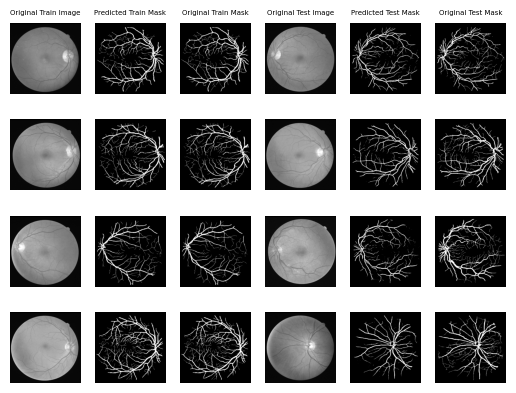

In [ ]:
evaluate_all_models(*unet_models[-1])

<ipython-input-25-97e24c7801ce>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


			unet - patches - finetuned
TRAIN:
	Loss: 0.5818959593772888
	AUC: 0.9864
	IOU: 0.696
----------------------------------------
TEST:
	Loss: 0.6054276108741761
	AUC: 0.9665
	IOU: 0.6002


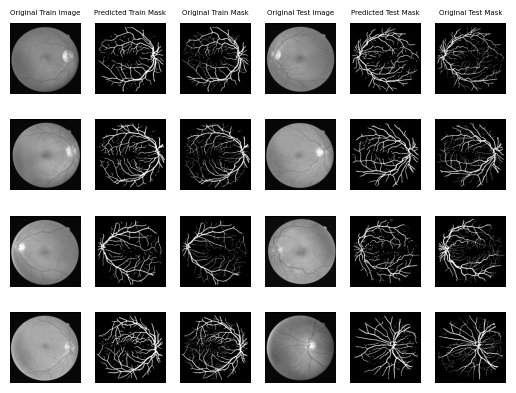

In [ ]:
evaluate_all_models("models/unet_model_patches-60-epochs.pth", "unet - patches - finetuned")

In [ ]:
pred = model(test[0].to(0))

In [ ]:
pred.shape

torch.Size([1, 1, 512, 512])

In [ ]:
train[2].shape

IndexError: tuple index out of range

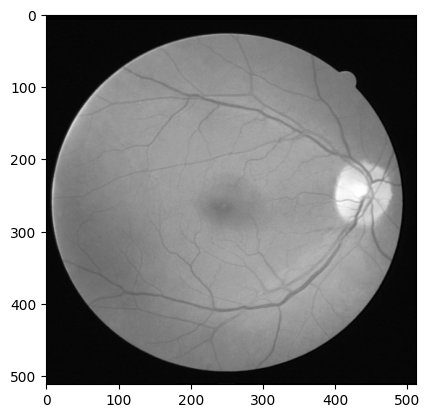

In [ ]:
plt.imshow(train[0][0,0].to('cpu'), 'gray')

In [ ]:
x_tr, y_tr, outputs_tr, train_loss = evaluate(model, train_loader, loss_fn, True)

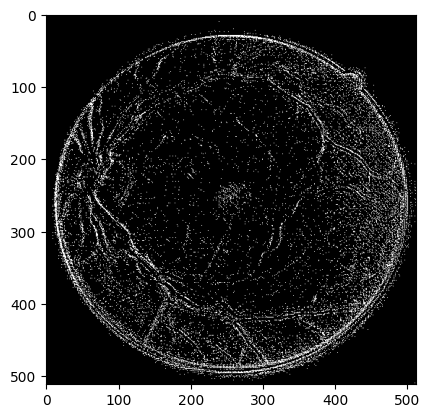

In [ ]:
plt.imshow(pred[0,0].detach().cpu()>0.5, 'gray')

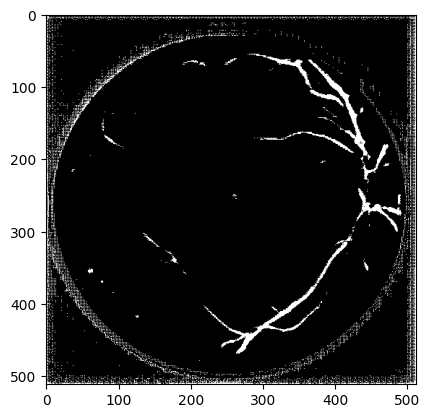

In [ ]:
plt.imshow(outputs_test[1,0].detach().cpu()>0, 'gray')

In [ ]:
outputs_test[0]>0

tensor([[[False, False, False,  ..., False,  True,  True],
         [ True,  True,  True,  ...,  True,  True,  True],
         [ True, False,  True,  ...,  True,  True,  True],
         ...,
         [ True,  True,  True,  ...,  True,  True,  True],
         [ True,  True,  True,  ...,  True,  True,  True],
         [ True,  True,  True,  ...,  True,  True,  True]]], device='cuda:0')

In [ ]:
x_test.shape, x_tr.shape

(torch.Size([4, 1, 512, 512]), torch.Size([4, 1, 512, 512]))

In [ ]:
x_test, y_test, outputs_test, test_loss = evaluate(model, test_loader, loss_fn, amp=True)

In [ ]:
metric_test = get_metrics(predict=outputs_test, target=y_test,threshold=0.5)

In [ ]:
metric_test

{'AUC': 0.9495,
 'F1': 0.791,
 'Acc': 0.9671,
 'Sen': 0.7775,
 'Spe': 0.9836,
 'Pre': 0.805,
 'IOU': 0.6543}